In [7]:
# If you run on colab uncomment the following line
#!pip install git+https://github.com/clementchadebec/benchmark_VAE.git

In [8]:
import torch
import torchvision.datasets as datasets

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-50000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

In [10]:
from pythae.models import VQVAE, VQVAEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.mnist.resnets import Encoder_ResNet_VQVAE_MNIST, Decoder_ResNet_VQVAE_MNIST

In [54]:
config = BaseTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-3,
    batch_size=100,
    num_epochs=20,
)


model_config = VQVAEConfig(
    latent_dim=16,
    input_dim=(1, 28, 28),
    commitment_loss_factor=0.25,
    quantization_loss_factor=1.0,
    num_embeddings=128,
    use_ema=True,
    decay=0.99
)

model = VQVAE(
    model_config=model_config,
    encoder=Encoder_ResNet_VQVAE_MNIST(model_config), 
    decoder=Decoder_ResNet_VQVAE_MNIST(model_config) 
)

In [55]:
pipeline = TrainingPipeline(
    training_config=config,
    model=model
)

In [56]:
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

Preprocessing train data...
Preprocessing eval data...

Using Base Trainer

Model passed sanity check !

Created my_model/VQVAE_training_2022-05-06_17-54-31. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !


























Eval of epoch 1/20: 100%|██████████| 100/100 [00:01<00:00, 54.85batch/s]
--------------------------------------------------------------------------
Train loss: 69.1909
Eval loss: 36.0371
--------------------------------------------------------------------------















Training of epoch 6/100:  23%|██▎       | 23/100 [00:11<00:00, 104.79batch/s]
















Eval of epoch 2/20: 100%|██████████| 100/100 [00:02<00:00, 37.93batch/s]
--------------------------------------------------------------------------
Train loss: 31.7487
Eval loss: 24.6216
--------------------------------------------------------------------------




















Eval of epoch 3/20: 100%|██████████| 100/100 [00:01<00:00, 68.6

In [57]:
import os

In [58]:
last_training = sorted(os.listdir('my_model'))[-1]
trained_model = VQVAE.load_from_folder(os.path.join('my_model', last_training, 'final_model'))

In [ ]:
recon = trained_model({'data': eval_dataset[:50]}).recon_x.detach().cpu()

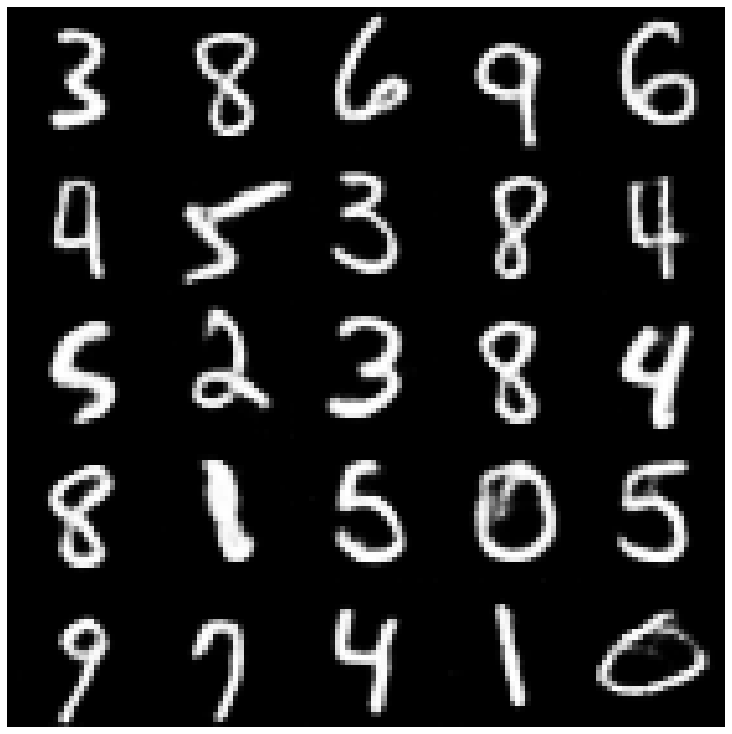

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(recon[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

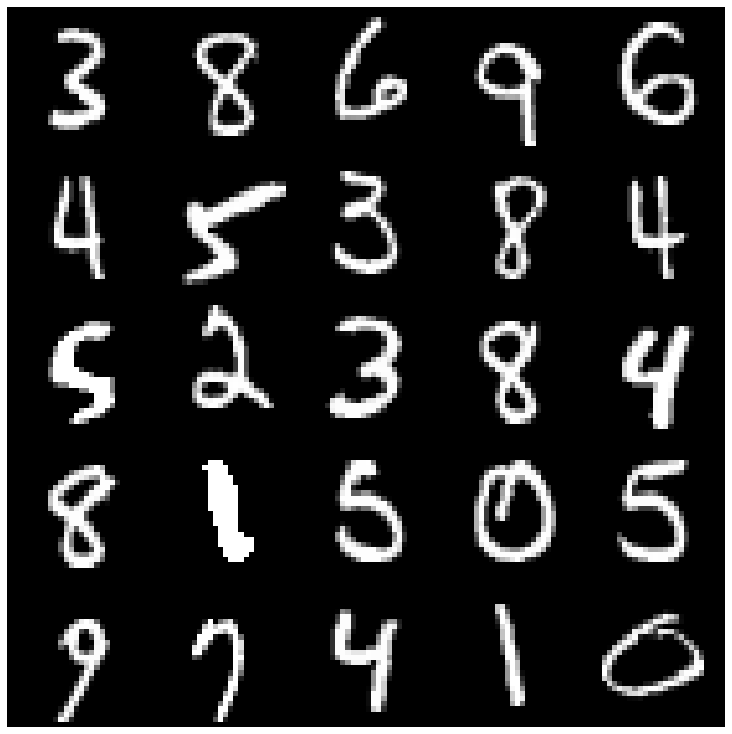

In [59]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(eval_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [71]:
from pythae.samplers import PixelCNNSampler, PixelCNNSamplerConfig
from pythae.trainers import BaseTrainerConfig
sampler_config = PixelCNNSamplerConfig(n_layers=3, kernel_size=5) 
pixelcnn_sampler = PixelCNNSampler(model=trained_model, sampler_config=sampler_config)

In [72]:
pixelcnn_sampler.fit(train_data=torch.tensor(train_dataset), eval_data=torch.tensor(eval_dataset), training_config=BaseTrainerConfig(num_epochs=30, learning_rate=1e-4))

/tmp/ipykernel_14068/1354367980.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixelcnn_sampler.fit(train_data=torch.tensor(train_dataset), eval_data=torch.tensor(eval_dataset), training_config=BaseTrainerConfig(num_epochs=30, learning_rate=1e-4))
Preprocessing train data...
Preprocessing eval data...

Using Base Trainer

Model passed sanity check !

Created dummy_output_dir/PixelCNN_training_2022-05-06_17-57-27. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !













Eval of epoch 1/30: 100%|██████████| 100/100 [00:00<00:00, 154.68batch/s]
--------------------------------------------------------------------------
Train loss: 4.6763
Eval loss: 4.5183
--------------------------------------------------------------------------













Eval of epoch 2/30: 100%|██████████| 10

In [73]:
gen_data = pixelcnn_sampler.sample(
    num_samples=100,
    #output_dir='generated/mnist/vae_2_stage_mnist'
)

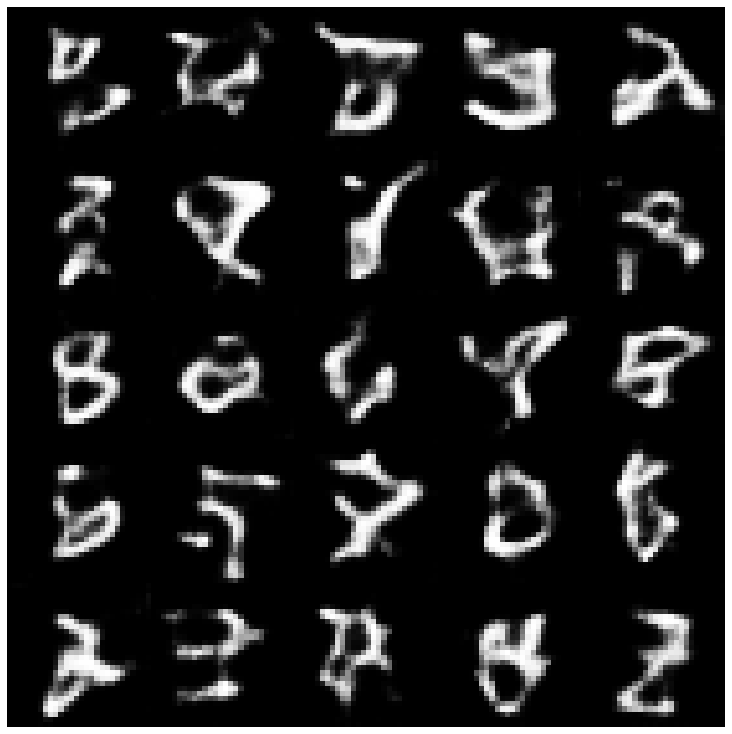

In [74]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))


for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().permute(1, 2, 0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

## ... the other samplers work the same